<a href="https://colab.research.google.com/github/Greg1172/ML/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [0]:
transform_train = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                           (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                           (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    transform=transform_train,
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    transform=transform_test,
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    shuffle=False,
    num_workers=2,
)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [0]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('relu', nn.ReLU())
model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))


In [0]:
import torchsummary

In [0]:
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
            Conv2d-3           [-1, 10, 28, 28]           5,770
           Flatten-4                 [-1, 7840]               0
            Linear-5                   [-1, 10]          78,410
Total params: 85,972
Trainable params: 85,972
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.00
Params size (MB): 0.33
Estimated Total Size (MB): 1.34
----------------------------------------------------------------


Train/Test F

In [0]:
def train(model, optim, criterion, dataloader, epoch, device):
  total = 0
  correct = 0
  train_loss = 0
  model.train()
  for data, label in dataloader:
    data, label = data.to(device), label.to(device)
    optim.zero_grad()
    output = model(data)
    loss = criterion(output, label)
    loss.backward()
    optim.step()

    train_loss += loss.item()
    pred = output.argmax(1)
    total += output.shape[0]
    correct += pred.eq(label).sum().item()
  return train_loss/total, 100.*correct/total

In [0]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
  total = 0
  correct = 0
  test_loss = 0
  model.eval()
  with torch.no_grad():
    for data, label in dataloader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      loss = criterion(output, label)
      test_loss += loss
      pred = output.argmax(1)
      correct += torch.eq(pred, label).sum().item()
      total += data.shape[0]
    acc = 100. * correct / total
    if acc > best_acc:
      #print('Saving...')
      state = {'net' : model.state_dict(), 'acc' : acc, 'epoch' : epoch}
      if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
      torch.save(state, './checkpoint/cktp_{}.pth'.format(model_name))
  return test_loss/total, acc

In [0]:
from IPython.display import clear_output
import numpy as np

Train model


In [0]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr = 0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

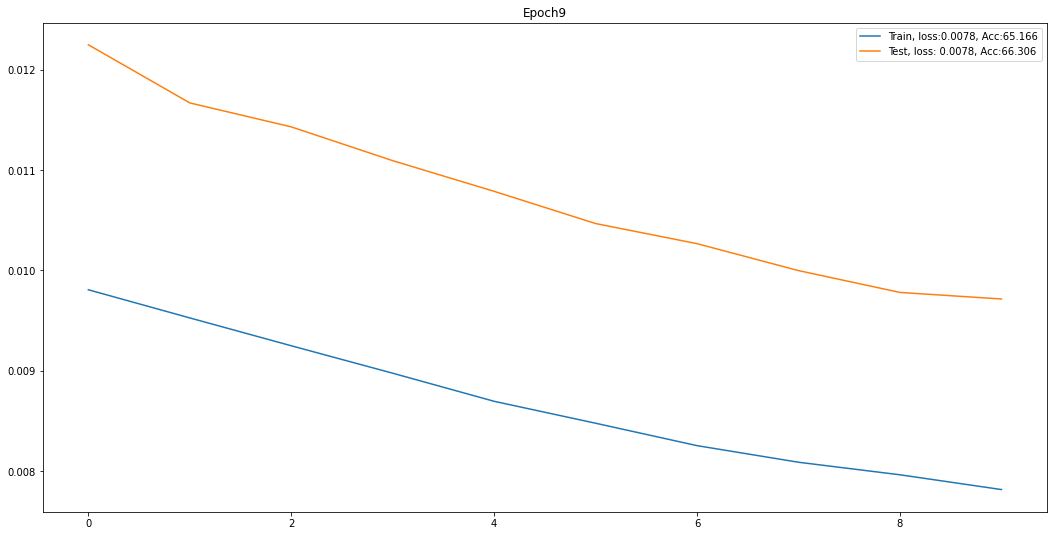

In [0]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
  train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
  train_losses.append(train_loss)
  test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc)
  scheduler.step(test_loss)
  test_losses.append(test_loss)
  best_acc = max(best_acc, test_acc)
  best_epoch = i if best_acc == test_acc else best_epoch
  clear_output()
  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss:{train_loss:.4f}, Acc:{train_acc}')
  plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {train_loss:.4f}, Acc:{test_acc}')
  plt.title(f'Epoch{i}')
  plt.legend(loc = 'best')
  plt.show()

In [0]:
best_acc

66.306

 Теперь попробуем с batch norm

In [0]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(3,64,3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [0]:
def train(model, optim, criterion, dataloader, epoch, device):
  total = 0
  correct = 0
  train_loss = 0
  model.train()
  for data, label in dataloader:
    data, label = data.to(device), label.to(device)
    optim.zero_grad()
    output = model(data)
    loss = criterion(output, label)
    loss.backward()
    optim.step()

    train_loss += loss.item()
    pred = output.argmax(1)
    total += output.shape[0]
    correct += pred.eq(label).sum().item()
  return train_loss/total, 100.*correct/total

In [0]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
  total = 0
  correct = 0
  test_loss = 0
  model.eval()
  with torch.no_grad():
    for data, label in dataloader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      loss = criterion(output, label)
      test_loss += loss
      pred = output.argmax(1)
      correct += torch.eq(pred, label).sum().item()
      total += data.shape[0]
    acc = 100. * correct / total
    if acc > best_acc:
      #print('Saving...')
      state = {'net' : model.state_dict(), 'acc' : acc, 'epoch' : epoch}
      if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
      torch.save(state, './checkpoint/cktp_{}.pth'.format(model_name))
  return test_loss/total, acc

In [0]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr = 0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

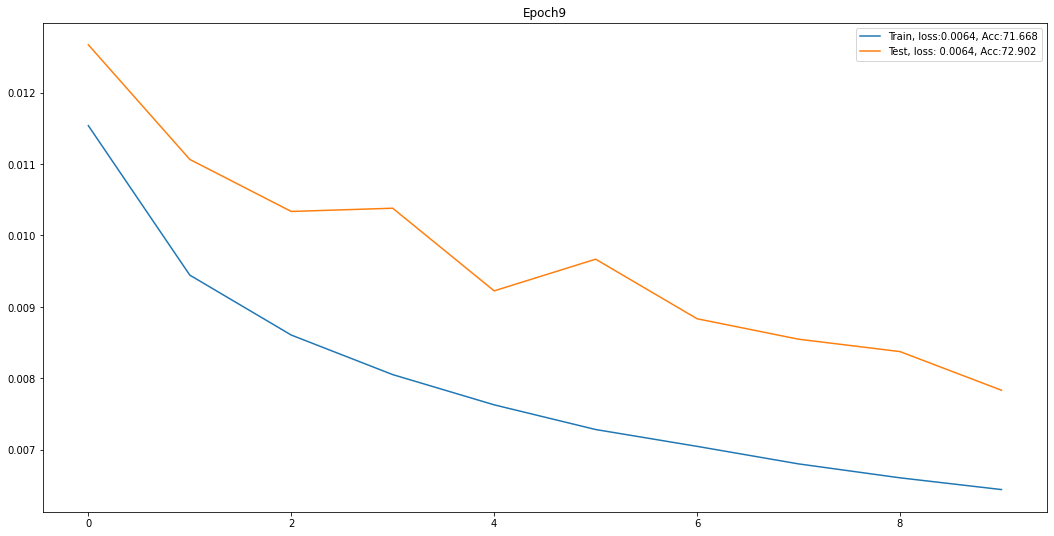

In [0]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
  train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
  train_losses.append(train_loss)
  test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc)
  scheduler.step(test_loss)
  test_losses.append(test_loss)
  best_acc = max(best_acc, test_acc)
  best_epoch = i if best_acc == test_acc else best_epoch
  clear_output()
  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss:{train_loss:.4f}, Acc:{train_acc}')
  plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {train_loss:.4f}, Acc:{test_acc}')
  plt.title(f'Epoch{i}')
  plt.legend(loc = 'best')
  plt.show()

In [0]:
best_acc

72.902